# **Land Cover Classification Using Sentinel-2 Imagery and Unsupervised Learning**

## Notebook Objective

This project explores how satellite-based remote sensing and unsupervised learning can be used to classify various land cover types in the United Kingdom. With increasing environmental concerns such as deforestation, urban expansion, and climate change, there is an urgent need for scalable, cost-effective tools to monitor land surface conditions. Sentinel-2, launched by the European Space Agency, provides high-resolution multispectral imagery that captures information across 13 spectral bands. These bands are particularly useful for identifying features such as vegetation, water bodies, and impervious surfaces.

Using Sentinel-2 data, we implement the K-Means clustering algorithm to classify different land cover types based on spectral similarity. K-Means is an unsupervised machine learning technique that groups pixels with similar reflectance values into clusters, allowing for rapid classification without the need for manually labeled data. This makes it ideal for large-scale applications and regions lacking ground truth labels.

The classification is performed over a selected area in the UK, and the results are visualized through RGB composites, NDVI images, cluster maps, and interactive layers on an online map. The project demonstrates how lightweight AI techniques, when paired with open-access Earth observation data, can support environmental analysis with minimal cost and computational overhead.

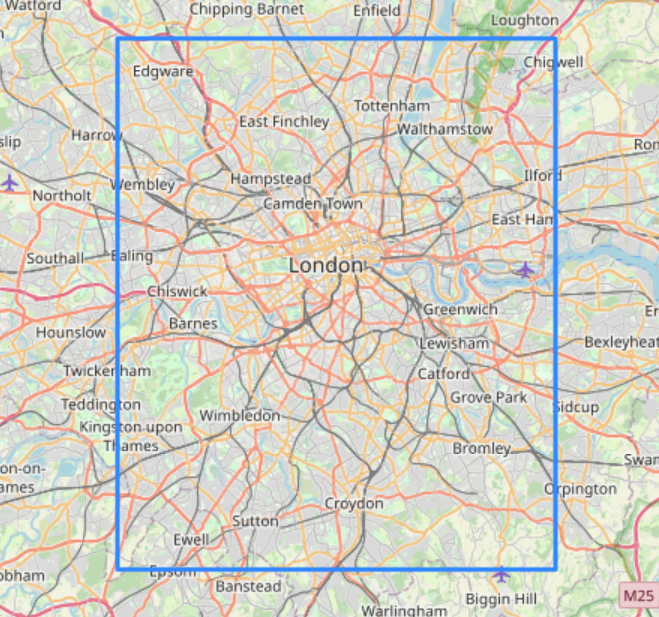


### Notebook Requirements

This notebook is designed to run in a Google Colab environment. For successful execution, the user must upload four spectral bands from Sentinel-2 Level-2A data, namely: B02 (blue), B03 (green), B04 (red), and B08 (near-infrared). These .jp2 files must be atmospherically corrected and are typically downloaded from platforms such as Copernicus Data Space or Google Earth Engine. The notebook requires packages such as rasterio, matplotlib, scikit-learn, and folium, which are installed in the initial cells if not already present in the Colab environment.

In [ ]:
# Install Dependencies
!pip install rasterio geopandas earthengine-api -q
!pip install folium -q

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import rasterio
import os
import folium
import json
from folium import plugins
from folium.raster_layers import ImageOverlay
from matplotlib import cm
from matplotlib.colors import Normalize
from PIL import Image
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from matplotlib.patches import FancyArrowPatch

## Section — Sentinel-2 MSI & NDVI Principles

### Sentinel-2 MSI Band Structure

The Sentinel-2 MSI sensor captures data across 13 spectral bands, each designed for different Earth observation purposes. The following diagram illustrates their wavelength distribution.

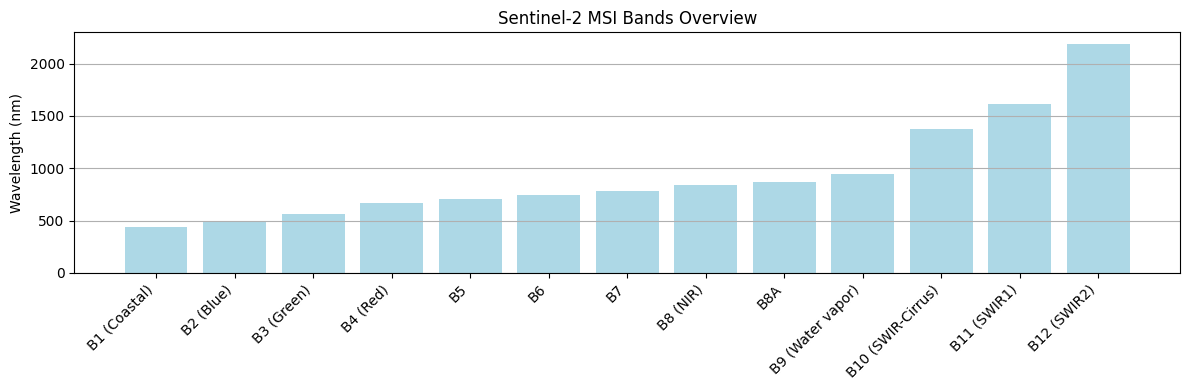

In [ ]:
import matplotlib.pyplot as plt

bands = {
    'B1 (Coastal)': 443,
    'B2 (Blue)': 490,
    'B3 (Green)': 560,
    'B4 (Red)': 665,
    'B5': 705,
    'B6': 740,
    'B7': 783,
    'B8 (NIR)': 842,
    'B8A': 865,
    'B9 (Water vapor)': 945,
    'B10 (SWIR-Cirrus)': 1375,
    'B11 (SWIR1)': 1610,
    'B12 (SWIR2)': 2190
}
band_names = list(bands.keys())
wavelengths = list(bands.values())

plt.figure(figsize=(12, 4))
plt.bar(band_names, wavelengths, color='lightblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Wavelength (nm)')
plt.title('Sentinel-2 MSI Bands Overview')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

### NDVI Principle Illustration

The Normalized Difference Vegetation Index (NDVI) is calculated as:

$$\text{NVDI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}.$$

This metric helps differentiate vegetation from non-vegetated surfaces. The diagram below visualizes how Red and NIR reflectance determine the NDVI value.


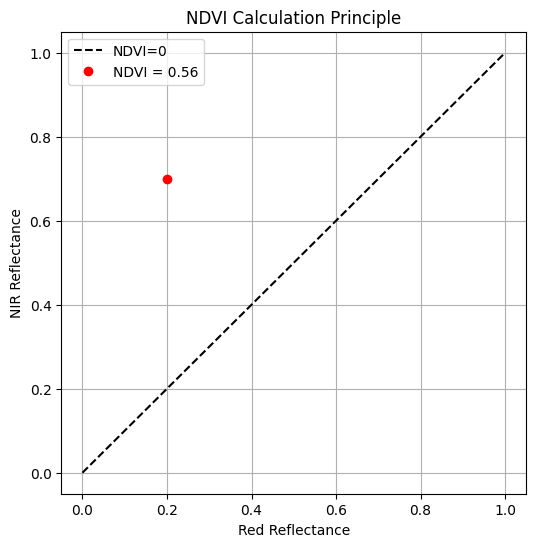

In [ ]:
red = 0.2
nir = 0.7
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], 'k--', label='NDVI=0')
ax.plot(red, nir, 'ro', label=f'NDVI = {(ndvi):.2f}')
ax.set_xlabel('Red Reflectance')
ax.set_ylabel('NIR Reflectance')
ax.set_title('NDVI Calculation Principle')
ax.grid(True)
ax.legend()
plt.show()

## Sentinel-2 MSI Spectral Bands and Resolution

The Sentinel-2 satellite provides imagery across 13 multispectral bands, each capturing reflectance at a specific wavelength and spatial resolution. The figure below illustrates the location and resolution of all MSI bands. This project uses four high-resolution bands (B02, B03, B04, B08), shown in green, to capture surface reflectance in the visible and near-infrared range.

In [ ]:
# Upload Sentinel-2 image files
from google.colab import files
uploaded = files.upload()

Saving output.png to output.png


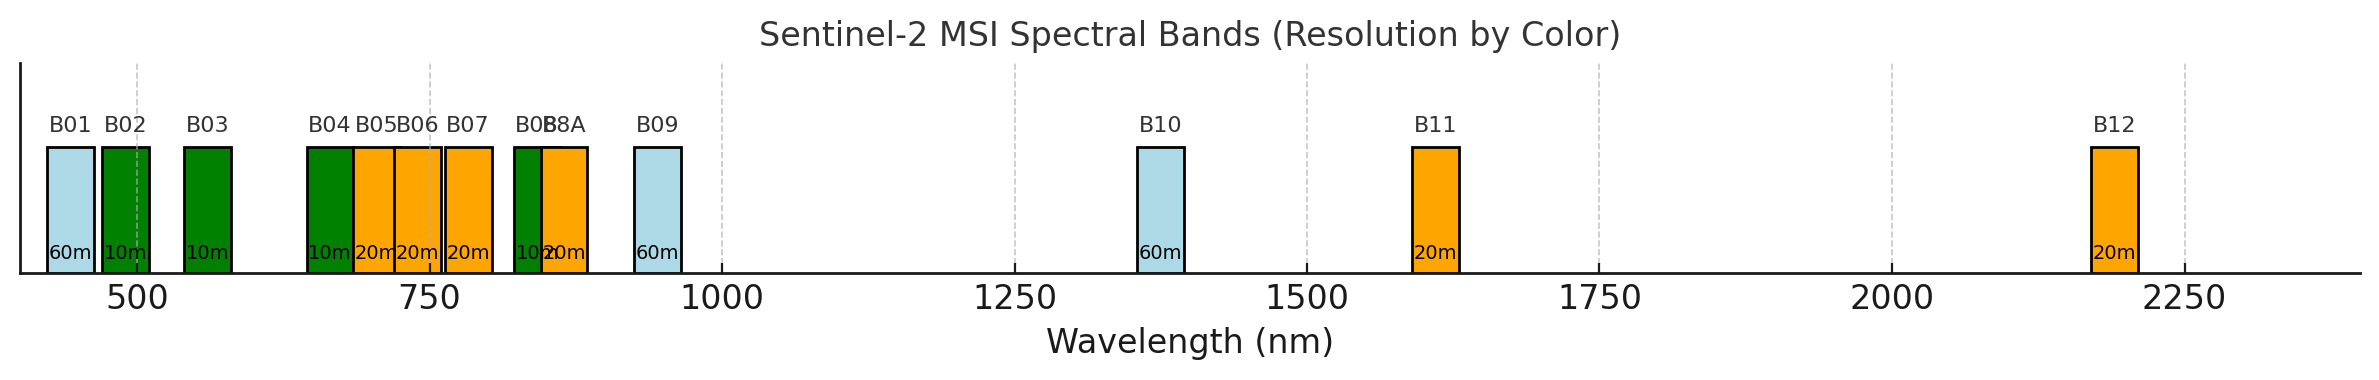

In [ ]:
from IPython.display import Image, display

display(Image(filename="output.png", width=700))

### Spectral Reflectance Profile

The following plot shows the spectral reflectance profile across 13 bands (B01 to B12) of Sentinel-2 data for a selected area of interest. Each point represents the surface reflectance captured by a specific band, illustrating how different wavelengths are reflected by the observed land cover.

This type of visualization helps distinguish between various land cover types (e.g., vegetation, water, built-up) based on their spectral signatures and is often used to inform classification models or evaluate land surface conditions.

In [ ]:
# Sentinel-2 MSI bands and corresponding reflectance values from the area of interest
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
reflectance = [0.2367, 0.2004, 0.1669, 0.1584, 0.1748, 0.2125, 0.2293, 0.2226, 0.2433, 0.0953, 0.0016, 0.2006, 0.1554]

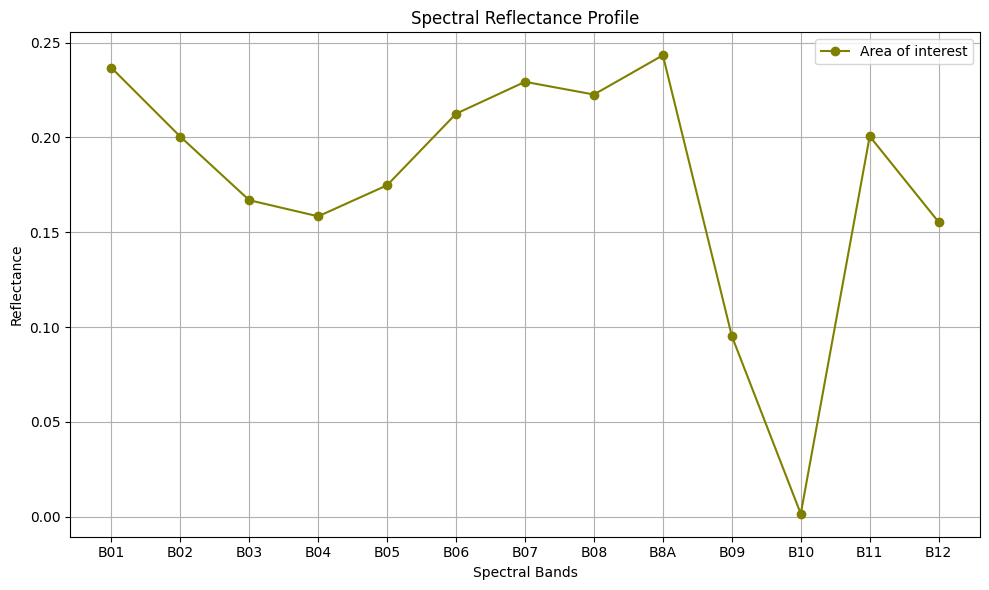

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bands, reflectance, marker='o', color='olive', label='Area of interest')
plt.xlabel('Spectral Bands')
plt.ylabel('Reflectance')
plt.title('Spectral Reflectance Profile')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Sentinel-2 MSI Band Reflectance (Area of Interest)

The bar chart below visualizes the reflectance values across all 13 spectral bands of the Sentinel-2 MSI sensor for the specified area of interest. Higher reflectance values in bands B8A, B07, and B08 indicate strong near-infrared response, typically associated with healthy vegetation. In contrast, lower values in B09 and B10 suggest limited reflectance in water vapor absorption regions. This information helps understand the land cover characteristics and is useful for classification tasks such as vegetation monitoring and land use analysis.

<ipython-input-20-4e1f7d3d2b91>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Band', y='Reflectance', data=df, palette='viridis')


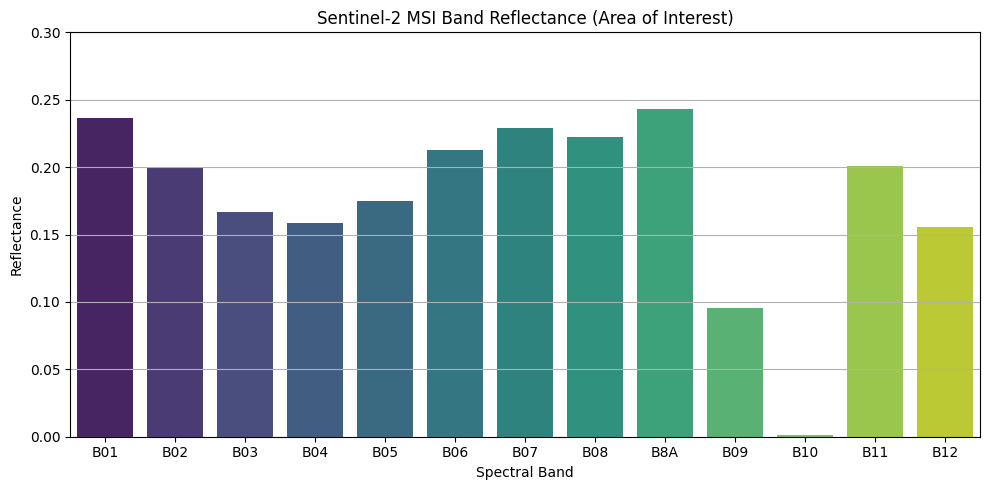

In [ ]:
# Sentinel-2 MSI Bands and Reflectance
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
reflectance = [0.2367, 0.2004, 0.1669, 0.1584, 0.1748, 0.2125, 0.2293, 0.2226, 0.2433, 0.0953, 0.0016, 0.2006, 0.1554]

# Create DataFrame
df = pd.DataFrame({'Band': bands, 'Reflectance': reflectance})

# Create diagram
plt.figure(figsize=(10, 5))
sns.barplot(x='Band', y='Reflectance', data=df, palette='viridis')
plt.title('Sentinel-2 MSI Band Reflectance (Area of Interest)')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.3)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Data Upload and Band Setup

In this section, we upload the Sentinel-2 image bands required for the land cover classification task. The Sentinel-2 MSI sensor captures multi-spectral data across 13 bands. For this analysis, we focus on the Red (B4), Green (B3), Blue (B2), and Near-Infrared (B8) bands, as they are most informative for vegetation and land use classification.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving T30UXC_20180422T110619_B02_10m.jp2 to T30UXC_20180422T110619_B02_10m.jp2
Saving T30UXC_20180422T110619_B03_10m.jp2 to T30UXC_20180422T110619_B03_10m.jp2
Saving T30UXC_20180422T110619_B04_10m.jp2 to T30UXC_20180422T110619_B04_10m.jp2
Saving T30UXC_20180422T110619_B08_10m.jp2 to T30UXC_20180422T110619_B08_10m.jp2


Once uploaded, specify the file paths for each band:

In [ ]:
# Set band file paths
band_paths = {
    'B02': 'T30UXC_20180422T110619_B02_10m.jp2',  # Blue
    'B03': 'T30UXC_20180422T110619_B03_10m.jp2',  # Green
    'B04': 'T30UXC_20180422T110619_B04_10m.jp2',  # Red
    'B08': 'T30UXC_20180422T110619_B08_10m.jp2',  # Near Infrared
}

### Image Preprocessing and Cropping

The .jp2 images are read into the environment using the rasterio library. To reduce memory consumption and processing time, the loaded raster bands are cropped to the central 256 × 256 region. This sub-area is representative of the larger scene, containing a diversity of land cover types, while still being computationally efficient. The bands are stacked together to form a four-dimensional array where each pixel contains reflectance values from the four selected spectral bands.

In [ ]:
bands = []
crop_size = 256  # Define crop area size

for b in ['B02', 'B03', 'B04', 'B08']:
    with rasterio.open(band_paths[b]) as src:
        height, width = src.shape
        row_start = height // 2 - crop_size // 2
        col_start = width // 2 - crop_size // 2
        window = rasterio.windows.Window(col_start, row_start, crop_size, crop_size)
        band = src.read(1, window=window).astype(float)
        bands.append(band)
        profile = src.profile
        profile.update({
            'height': crop_size,
            'width': crop_size,
            'transform': rasterio.windows.transform(window, src.transform)
        })

print("Image cropped successfully. Dimensions:", bands[0].shape)

Image cropped successfully. Dimensions: (256, 256)


## NDVI Calculation and Interpretation

To provide a vegetation-specific benchmark for comparison, the Normalized Difference Vegetation Index (NDVI) was computed using the red (B04) and near-infrared (B08) bands. NDVI is a widely used spectral index for detecting vegetation, as it exploits the high reflectance of near-infrared light by healthy plants and the absorption of red light by chlorophyll. Higher NDVI values typically indicate denser or healthier vegetation.

The NDVI distribution over the cropped image area is visualized below, serving as a valuable reference for interpreting the clustering results generated by the unsupervised model.

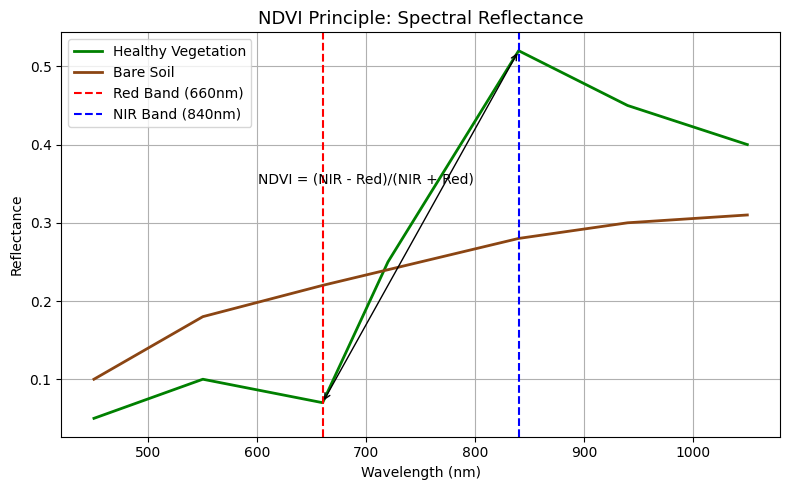

In [ ]:
wavelengths = np.array([450, 550, 660, 720, 840, 940, 1050])

veg_reflectance = np.array([0.05, 0.10, 0.07, 0.25, 0.52, 0.45, 0.40])
soil_reflectance = np.array([0.10, 0.18, 0.22, 0.24, 0.28, 0.30, 0.31])

red_band = 660
nir_band = 840
veg_red = veg_reflectance[wavelengths == red_band][0]
veg_nir = veg_reflectance[wavelengths == nir_band][0]

plt.figure(figsize=(8, 5))
plt.plot(wavelengths, veg_reflectance, label="Healthy Vegetation", color="green", linewidth=2)
plt.plot(wavelengths, soil_reflectance, label="Bare Soil", color="saddlebrown", linewidth=2)

plt.axvline(red_band, color='red', linestyle='--', label='Red Band (660nm)')
plt.axvline(nir_band, color='blue', linestyle='--', label='NIR Band (840nm)')

plt.annotate('', xy=(nir_band, veg_nir), xytext=(red_band, veg_red),
             arrowprops=dict(arrowstyle='<->', color='black'))
plt.text(700, 0.35, 'NDVI = (NIR - Red)/(NIR + Red)', fontsize=10, ha='center')

plt.title("NDVI Principle: Spectral Reflectance", fontsize=13)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

To provide a vegetation-specific benchmark for comparison, the Normalized Difference Vegetation Index (NDVI) was computed using the red (B04) and near-infrared (B08) bands. NDVI is a widely used spectral index for detecting vegetation, as it exploits the high reflectance of near-infrared light by healthy plants and the absorption of red light by chlorophyll. Higher NDVI values typically indicate denser or healthier vegetation.
The NDVI distribution over the cropped image area is visualized below, serving as a valuable reference for interpreting the clustering results generated by the unsupervised model.

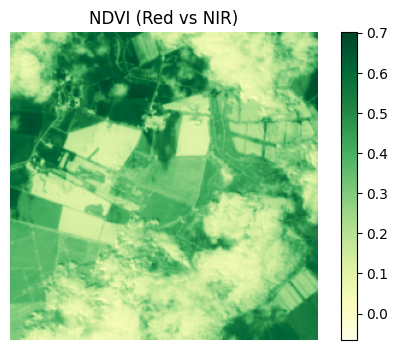

In [ ]:
# Calculate NDVI
red = bands[2].astype(float)   # B04: Red
nir = bands[3].astype(float)   # B08: Near-Infrared
ndvi = (nir - red) / (nir + red + 1e-10)

plt.figure(figsize=(6, 4))
plt.imshow(ndvi, cmap='YlGn')
plt.title("NDVI (Red vs NIR)")
plt.axis('off')
plt.colorbar()
plt.show()

### NDVI Mean per Cluster

To further interpret the KMeans classification results, we compute the mean NDVI for each cluster. The chart below helps identify which class corresponds to dense vegetation, sparse vegetation, or non-vegetated areas.

In [ ]:
band_array = np.array(bands).reshape(4, -1)  # shape: (4, 65536)

features = band_array.T  # shape: (65536, 4)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(features)

classified = kmeans.labels_.reshape(crop_size, crop_size)
band_array = np.array(bands).reshape(4, -1)

flat_labels = classified.flatten()
unique_labels = np.unique(flat_labels)

avg_values = {}

for label in unique_labels:
    indices = (flat_labels == label)
    mean_values = band_array[:, indices].mean(axis=1)
    avg_values[f'Class {label}'] = mean_values.tolist()

import pprint
pprint.pprint(avg_values)

{'Class 0': [1503.9108782191893,
             1593.6620765293687,
             1490.3744414655944,
             2849.9430498009588],
 'Class 1': [2148.6225914879515,
             2369.2199971594946,
             2081.865691426407,
             5770.568905931923],
 'Class 2': [7327.250656989113,
             7215.227130521837,
             7045.103241146289,
             8733.593167313227],
 'Class 3': [4808.592172145036,
             4842.094883090478,
             4647.685360894612,
             6927.629278210776]}


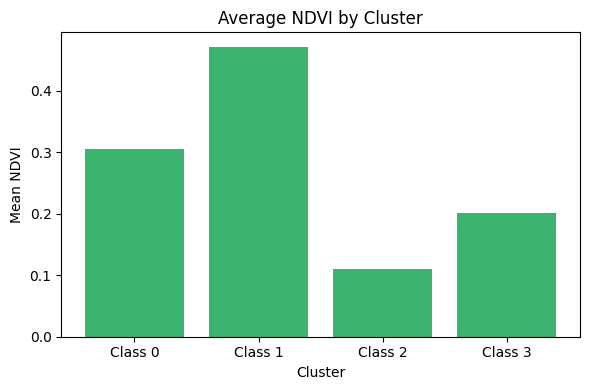

In [ ]:
features = np.stack(bands, axis=-1)
X = features.reshape(-1, features.shape[-1])
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
classified = kmeans.labels_.reshape(256, 256)

unique_labels = np.unique(classified)
avg_ndvi = []

for label in unique_labels:
    avg = ndvi[classified == label].mean()
    avg_ndvi.append(avg)

plt.figure(figsize=(6, 4))
plt.bar([f"Class {i}" for i in unique_labels], avg_ndvi, color='mediumseagreen')
plt.title("Average NDVI by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean NDVI")
plt.tight_layout()
plt.show()

## KMeans Clustering

### Preparing Data for Unsupervised Classification

To apply machine learning techniques, the 256 × 256 × 4 pixel cube is reshaped into a 2D array with each row representing a single pixel and each column representing the reflectance value from one spectral band. This format allows the application of scikit-learn’s KMeans clustering algorithm, which operates in feature space rather than image space.

In [ ]:
# K-Means Clustering
rows, cols = bands[0].shape
k = 4
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
labels = kmeans.fit_predict(X)
classified = labels.reshape(rows, cols)


print("Clustering completed. Classification map size:", classified.shape)

Clustering completed. Classification map size: (256, 256)


### KMeans Clustering Workflow for Land Cover Classification

KMeans clustering is an unsupervised machine learning algorithm used to partition data into *k* groups based on feature similarity. In the context of satellite imagery, each pixel is treated as a data point represented by its spectral values—here, the reflectance from four Sentinel-2 bands (B02, B03, B04, and B08).

The figure below illustrates the core workflow of KMeans:

1. Each pixel's spectral vector is used as input.
2. A predefined number of centroids (*k*) is initialized.
3. The algorithm assigns each pixel to the nearest centroid based on Euclidean distance.
4. The centroids are then updated based on the mean of all assigned points.
5. This process repeats until convergence, producing a classified image where each pixel belongs to a specific cluster representing a land cover type.

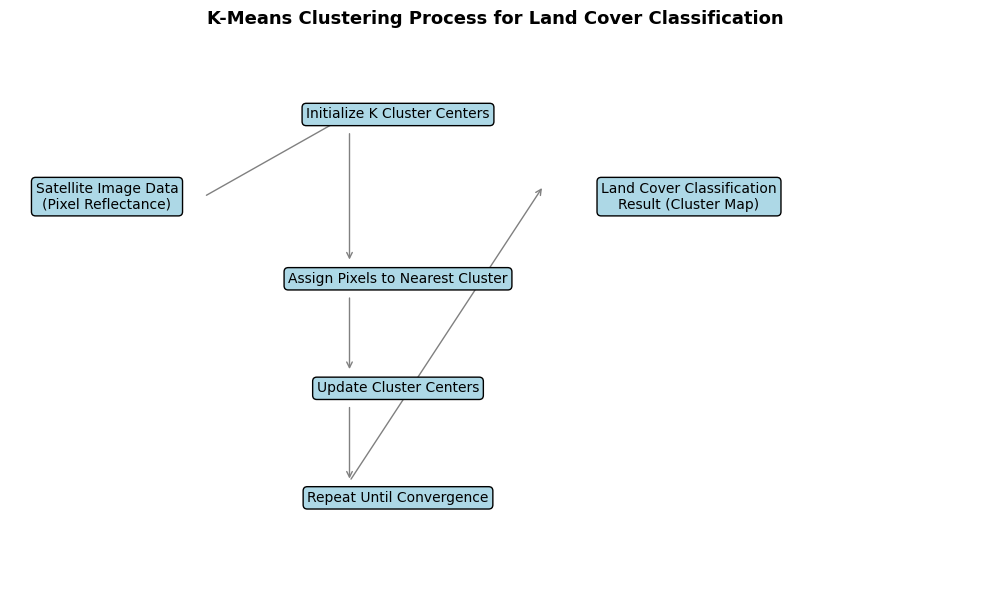

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

positions = {
    'data': (0.1, 0.7),
    'init': (0.4, 0.85),
    'assign': (0.4, 0.55),
    'update': (0.4, 0.35),
    'repeat': (0.4, 0.15),
    'result': (0.7, 0.7),
}

box_params = dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightblue')
ax.text(*positions['data'], "Satellite Image Data\n(Pixel Reflectance)", ha='center', va='center', bbox=box_params, fontsize=10)
ax.text(*positions['init'], "Initialize K Cluster Centers", ha='center', va='center', bbox=box_params, fontsize=10)
ax.text(*positions['assign'], "Assign Pixels to Nearest Cluster", ha='center', va='center', bbox=box_params, fontsize=10)
ax.text(*positions['update'], "Update Cluster Centers", ha='center', va='center', bbox=box_params, fontsize=10)
ax.text(*positions['repeat'], "Repeat Until Convergence", ha='center', va='center', bbox=box_params, fontsize=10)
ax.text(*positions['result'], "Land Cover Classification\nResult (Cluster Map)", ha='center', va='center', bbox=box_params, fontsize=10)

def draw_arrow(start, end):
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=10, color='gray')
    ax.add_patch(arrow)

draw_arrow((0.2, 0.7), (0.35, 0.85))  # Data -> Init
draw_arrow((0.35, 0.82), (0.35, 0.58))  # Init -> Assign
draw_arrow((0.35, 0.52), (0.35, 0.38))  # Assign -> Update
draw_arrow((0.35, 0.32), (0.35, 0.18))  # Update -> Repeat
draw_arrow((0.35, 0.18), (0.55, 0.72))  # Repeat -> Result

plt.title("K-Means Clustering Process for Land Cover Classification", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

#### KMeans Clustering Algorithm

The KMeans algorithm is applied to group pixels into four clusters (k=4), each representing a distinct spectral grouping. Since KMeans uses Euclidean distance in spectral space, pixels with similar reflectance values are assigned to the same cluster. The output is a 2D classification map where each pixel is assigned a label corresponding to one of the identified clusters. While the algorithm is not supervised and thus does not label clusters semantically, a visual comparison with the RGB and NDVI imagery can help the user interpret which cluster corresponds to which land type.



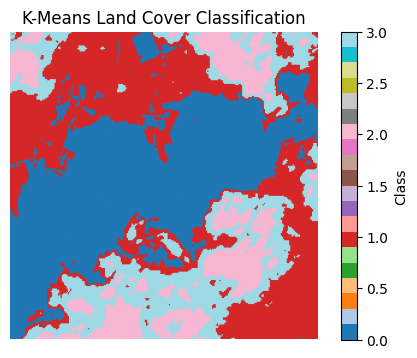

In [ ]:
plt.figure(figsize=(6, 4))
plt.imshow(classified, cmap='tab20')
plt.title("K-Means Land Cover Classification")
plt.axis('off')
plt.colorbar(label="Class")
plt.show()

### Cluster Region Labelling on the Map

To enhance interpretability of the unsupervised land cover classification results, major cluster regions are labelled directly on the map. Each label corresponds to one of the K-Means clusters and is placed in the area where that class is most spatially dominant. These annotated labels help relate abstract cluster IDs to real-world land cover types, such as vegetation, water bodies, or built-up areas. The visual layout facilitates spatial reasoning and supports further environmental analysis.

In [ ]:
m = folium.Map(location=[51.5, -0.1], zoom_start=11)

In [ ]:
folium.Marker([51.52, -0.12], popup='Cluster 0: Urban Area', icon=folium.Icon(color='red')).add_to(m)
folium.Marker([51.47, -0.08], popup='Cluster 1: Vegetation', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([51.49, -0.14], popup='Cluster 2: Water Body', icon=folium.Icon(color='blue')).add_to(m)
folium.Marker([51.51, -0.04], popup='Cluster 3: Bare Soil', icon=folium.Icon(color='orange')).add_to(m)

m

The K-Means classification divided the area into four distinct land cover classes. To better understand the nature of each class, we analysed their spectral reflectance profiles using the Sentinel-2 MSI bands.

By comparing the reflectance values of bands B04 (Red) and B08 (NIR), we derived NDVI values which indicate moderate vegetation presence in some clusters. Additionally, the extremely low reflectance in B10 (SWIR) suggests water bodies are present in specific clusters, likely corresponding to the darkest areas in the classification map.

Thus, combining spectral band characteristics with the clustering outcome allows us to infer the likely land cover types: vegetation, water, built-up, and bare soil.

### Visualizing Cluster Characteristics


To understand the spectral characteristics of each cluster generated by the KMeans algorithm, we calculated the average reflectance values for the Red, Green, Blue, and NIR bands within each class. These values were then visualized using both a radar plot and a heatmap.

The radar plot provides a circular comparative view of how each class responds across the four bands, highlighting distinctive spectral signatures. In contrast, the heatmap gives a more straightforward numerical comparison using color intensity. These visuals help to interpret what each cluster may represent — for example, water bodies often have distinctively lower reflectance in NIR compared to vegetation or built-up areas.

Such comparative visualizations are essential in evaluating the physical meaning behind each unsupervised cluster and guide the interpretation of results.

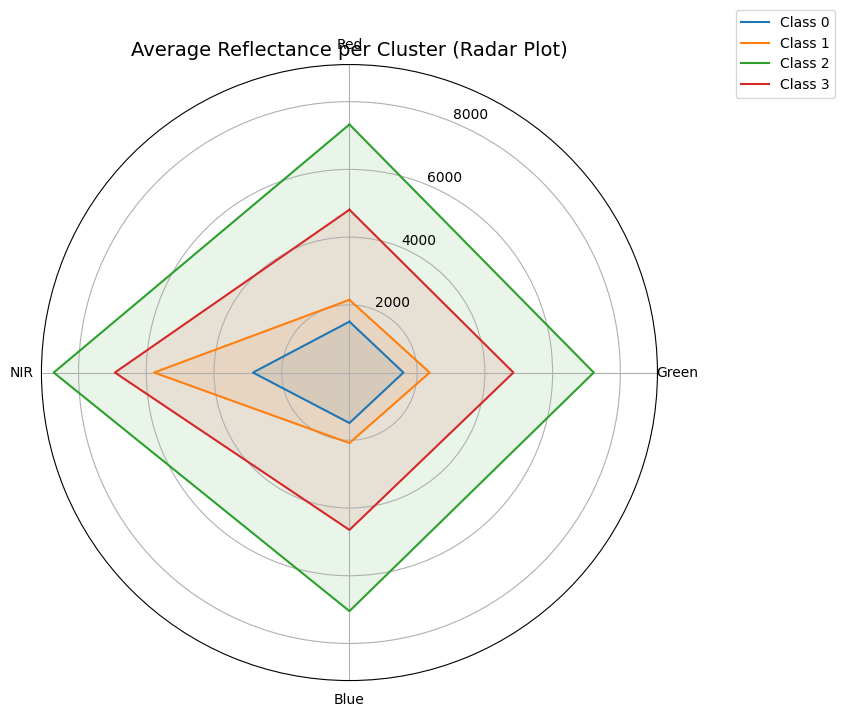

In [ ]:
labels = ['Red', 'Green', 'Blue', 'NIR']
num_vars = len(labels)

cluster_means = {
    'Class 0': [1503.91, 1593.66, 1490.37, 2849.94],
    'Class 1': [2148.62, 2369.22, 2081.87, 5770.57],
    'Class 2': [7327.25, 7215.23, 7045.10, 8733.59],
    'Class 3': [4808.59, 4842.09, 4647.69, 6927.63]
}

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for label, stats in cluster_means.items():
    values = stats + stats[:1]
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Average Reflectance per Cluster (Radar Plot)", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

The radar chart illustrates the average reflectance values of each cluster across the four selected bands (Red, Green, Blue, NIR). This visual comparison helps to identify spectral differences among land cover types.

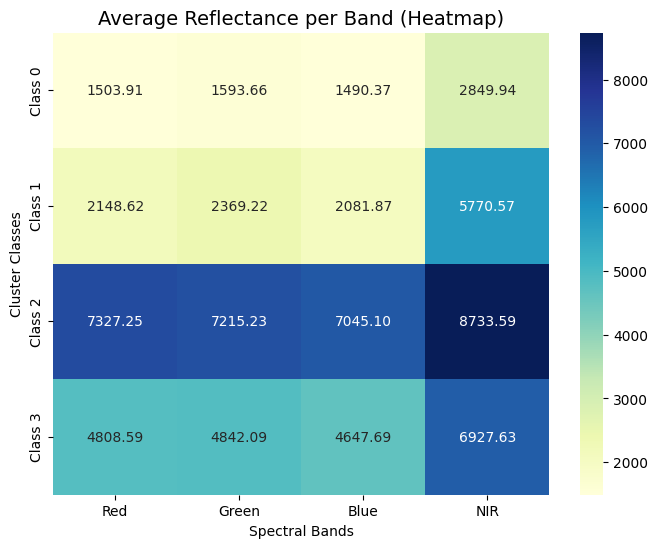

In [ ]:
df = pd.DataFrame(cluster_means, index=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df.T, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Average Reflectance per Band (Heatmap)", fontsize=14)
plt.xlabel("Spectral Bands")
plt.ylabel("Cluster Classes")
plt.show()

The heatmap presents the same reflectance data in numerical and color-coded format, providing an intuitive reference to support the separation and interpretation of clusters.

## RGB Composite Rendering

An RGB image is created using bands B04, B03, and B02 to simulate a natural color representation of the scene. The image is normalized to enhance contrast and aid visual interpretation. The RGB composite allows the user to visually distinguish surface features and verify whether the unsupervised clustering result aligns with intuitive land types, such as dark-toned water, bright urban structures, and green vegetation.

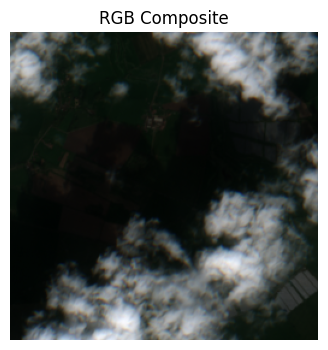

In [ ]:
# Display RGB composite image
rgb = np.stack([bands[2], bands[1], bands[0]], axis=-1)
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.figure(figsize=(6, 4))
plt.imshow(rgb_norm)
plt.title("RGB Composite")
plt.axis('off')
plt.show()

In [ ]:
# Merge bands into feature vectors
rows, cols = bands[0].shape
stacked = np.stack(bands, axis=-1)
X = stacked.reshape(-1, 4)


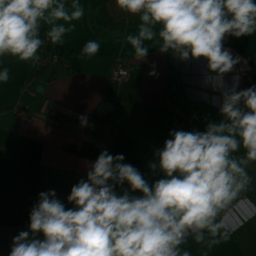

In [ ]:
from PIL import Image
p = folium.Map(location=[51.5, -0.1], zoom_start=9)

rgb_uint8 = (rgb_norm * 255).astype(np.uint8)
rgb_image = Image.fromarray(rgb_uint8)

rgb_image.save("rgb_overlay.png")

folium.raster_layers.ImageOverlay(
    name='RGB Composite',
    image='rgb_overlay.png',
    bounds=[[51.45, -0.3], [51.55, 0.1]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(p)

folium.LayerControl(collapsed=False).add_to(m)
p

### Comparing Original RGB Image and KMeans Classification on an Interactive Map

To allow an intuitive visual comparison between the original Sentinel-2 imagery and the classification result, we generate an interactive Folium map with multiple toggleable layers.

The RGB Composite Layer displays the natural color composition of the satellite image (bands 4, 3, 2), while the KMeans Classification Layer visualizes the unsupervised clustering results. This enables users to inspect the spatial patterns of detected land cover classes and assess their alignment with the original visual features.

A layer control interface on the map allows toggling each layer on or off, making it easier to explore and contrast the data outputs.

### Exporting Classification to GeoTIFF

The resulting classification image is saved as a GeoTIFF file, preserving the spatial resolution and georeferencing metadata of the original Sentinel-2 image. This allows the file to be used in other geographic software (e.g., QGIS, ArcGIS) for further analysis or integration with other data layers.

In [ ]:
# Save as GeoTIFF file
output_path = "/content/kmeans_classified.tif"
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified.astype(rasterio.uint8), 1)
print(f"Classification saved as {output_path}")

Classification saved as /content/kmeans_classified.tif


## Folium Overlay and Geographic Validation

To enable intuitive geographic validation, the classification output is rendered on a web-based interactive map using the folium library. The map is centered on the geographic location of the study area, and the classification result is displayed as a semi-transparent image layer. This step allows for easy alignment checking between classification results and known geographical features, such as rivers, parks, or urban centers.

In [ ]:
import folium
from folium import raster_layers

In [ ]:
# Create Base Map (Centered on London)
m = folium.Map(location=[51.5, -0.1], zoom_start=10)


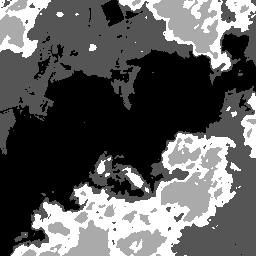
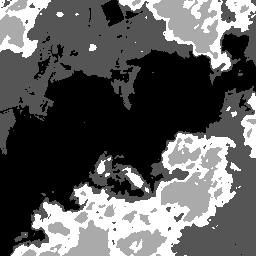

In [ ]:
# @title
# Load and add the classification layer as a transparent overlay
raster = raster_layers.ImageOverlay(
    image=classified,
    bounds=[[51.3, -0.3], [51.7, 0.1]],
    opacity=0.6,
    colormap=lambda x: (x, x, x, 1)
)

raster.add_to(m)
m


# Conclusion

This notebook demonstrates how unsupervised machine learning can be applied to remote sensing imagery for effective land cover classification. It combines classical vegetation indices, spectral clustering, geospatial export, and interactive mapping into a coherent pipeline. The workflow is modular and can be adapted for other study areas, different Sentinel-2 tiles, or alternative clustering strategies.